# Introduction

Continual learning for semantic segmentation is a field that has emerged recently and is quickly evolving. As a newcomer to the field, I wanted to quickly get in touched with the popular approaches and see by myself some concrete results. However, if one wants to rerun the experiments made in recent papers, which often use medium- to large-scale datasets such as Pascal-VOC, ADE20K or COCO, it would require several hours of training. 

Therefore, I took inspiration from the [Simple Deep Learning project](https://https://awaywithideas.com/mnist-extended-a-dataset-for-semantic-segmentation-and-object-detection/) by Luke Tonin in which he built MNIST-Extended, a semantic segmentation dataset  made from MNIST. While this is obviously a toy dataset, it has the benefit of giving quick feedback when tinkering with models.

This will also enable to explore common challenges of continual semantic segmentation such as Catastrophic forgetting, background shift, and the various combinations of setups where past/future classes are/are not in images and labeled as background. 

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**Using MNIST data for CL: Split MNIST benchmark**

In [29]:
# some initial imports
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
import os
os.chdir("/content/gdrive/MyDrive/Colab Notebooks/mnist-continual-seg")
import sys
sys.path.append("/content/gdrive/MyDrive/Colab Notebooks/simple_deep_learning")

In [30]:
import simple_deep_learning
from simple_deep_learning.mnist_extended import semantic_segmentation

In [4]:
train_x, train_y, test_x, test_y = semantic_segmentation.create_semantic_segmentation_dataset(num_train_samples=500,num_test_samples=100)

11501568/11490434 [==============================] - 0s 0us/step


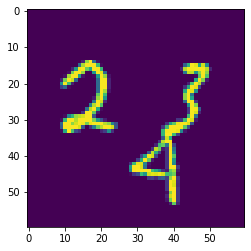

In [5]:
plt.imshow(train_x[1,:,:,0])

Now that the segmentation dataset is loaded, we need to adapt it to reflect the continual setup where classes are seen sequentially. To do so, we will implement a processing function that only keeps the groundtruth masks for the current learning step. For instance, if we divide the 10 classes from MNIST in 5 learning steps of 2 classes, then at step #0 the model is only trained to segment digits 0 and 1, while other digits on the image are labeled as background (i.e. label '0'). Then, at step #1 where the model must learn to segment 2's and 3's, digits 0-1 and 4-9 will be labeled as background, and so on.

This scenario reflects the common experimental setup in which segmentation masks are only available for current classes while objects that belong to past and future classes can still appear in scene images (e.g. from Pascal-VOC) but are labeled as background. This is a challenge specific to Continual Semantic Segmentation known as Background shift, which is addressed in several recent works (MiB, PLOP, SSUL, RECALL, etc). 

In [189]:
import torch.utils.data as data
class continual_mnist_extended(data.Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y
    self.classes = np.arange(self.y.shape[-1])
    self.tasks = {0: [0,1], 1: [2,3], 2: [4,5], 3: [6,7], 4: [8,9]}
    self.curr_task_id = 0
    self.curr_classes = self.set_curr_classes()
    self.curr_X, self.curr_y = self.get_curr_Xy()

  def process_groundtruth(self, segmentation_masks):
    processed_masks = []
    num_classes = segmentation_masks.shape[-1]
    for i in range(len(segmentation_masks)):
      mask = np.copy(segmentation_masks[i])
      for j in range(num_classes):
        if j not in self.tasks[self.curr_task_id]:
          mask[:,:,j] = 0
      processed_masks.append(mask)

    return np.array(processed_masks)

  def set_curr_classes(self):
    curr_classes = self.tasks[self.curr_task_id]
    return curr_classes

  def next_task(self):
    self.curr_task_id += 1
    if self.curr_task_id >= len(self.tasks):
      self.curr_task_id = 0

    self.curr_classes = self.curr_classes + self.set_curr_classes()
    self.curr_X, self.curr_y = self.get_curr_Xy()

  def get_curr_Xy(self):
    processed_y = self.process_groundtruth(self.y)
    idx = np.where(np.sum(processed_y, axis=(1,2,3))!=0)[0]
    processed_X = self.X[idx]
    processed_y = processed_y[idx]
    processed_X = np.transpose(processed_X, (0,3,1,2))
    processed_y = np.transpose(processed_y, (0,3,1,2))

    return processed_X, processed_y


  def __getitem__(self, index):
    return self.curr_X[index], self.curr_y[index, self.curr_classes]

  def __len__(self):
    return len(self.curr_X)

In [221]:
test_data = continual_mnist_extended(test_x, test_y)
test_data.next_task()
test_loader = data.DataLoader(test_data, batch_size=1)

In [191]:
a = next(iter(test_loader))

In [192]:
a[1].shape

torch.Size([8, 4, 60, 60])

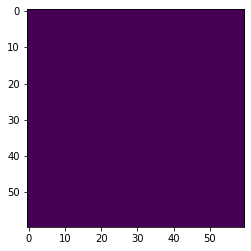

In [208]:
plt.imshow(a[1][6][0])

In [209]:
class simple_seg_model(torch.nn.Module):
  def __init__(self, conv_filters=32, n_classes=2):
    super(simple_seg_model, self).__init__()
    self.conv_filters = conv_filters
    self.n_classes = n_classes

    self.conv1 = torch.nn.Conv2d(1, self.conv_filters, (3,3), padding=1)
    self.conv2 = torch.nn.Conv2d(self.conv_filters, self.conv_filters, (3,3), padding=1)
    self.conv3 = torch.nn.Conv2d(self.conv_filters, self.conv_filters, (3,3), padding=1)
    self.conv4 = torch.nn.Conv2d(self.conv_filters, self.conv_filters, (3,3), padding=1)
    self.conv5 = torch.nn.Conv2d(self.conv_filters, self.conv_filters, (3,3), padding=1)
    self.conv6 = torch.nn.Conv2d(self.conv_filters, self.conv_filters, (3,3), padding=1)
    self.conv7 = torch.nn.Conv2d(self.conv_filters, self.conv_filters, (3,3), padding=1)

    self.cls = nn.ModuleList(
            [nn.Conv2d(self.conv_filters, c, 1) for c in n_classes]
        )

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = F.relu(self.conv3(x))
    x = F.relu(self.conv4(x))
    x = F.relu(self.conv5(x))
    x = F.relu(self.conv6(x))
    x = F.relu(self.conv7(x))
    out = []
    for mod in self.cls:
        out.append(mod(x))
    x_o = torch.cat(out, dim=1)
    x_o = torch.sigmoid(x_o)

    return x_o

s = simple_seg_model(n_classes=[2])

In [210]:
s(torch.Tensor(np.zeros((1, 1, 60, 60)))).shape

torch.Size([1, 2, 60, 60])

In [211]:
class Trainer:
  def __init__(self, model, n_classes, curr_task=0):
    self.model = model
    self.criterion = torch.nn.BCELoss()
    self.n_classes = n_classes
    self.curr_task = curr_task

  def next_task(self, new_classes):
    path = f"checkpoints/task-{self.curr_task}.pth"
    step_checkpoint = torch.load(path, map_location="cpu")

    #old_model = simple_seg_model(n_classes=self.n_classes)
    #old_model.load_state(step_checkpoint['model_state'], strict=True)

    self.n_classes = new_classes

    new_model = simple_seg_model(n_classes=self.n_classes)
    new_model.load_state_dict(step_checkpoint, strict=False)

    self.model = new_model.cuda()
    self.curr_task += 1

  def train(self, cur_epoch, optim, train_loader):

    model = self.model
    model.train()

    for cur_step, (images, labels) in enumerate(train_loader):
      images, labels = images.cuda().float(), labels.cuda().float()
      optim.zero_grad()

      outputs = model(images)
      loss = self.criterion(outputs, labels).mean()
      loss.backward()
      optim.step()
      #print(loss)


In [212]:
train_data.curr_classes

[0, 1, 2, 3]

In [213]:
train_data = continual_mnist_extended(train_x, train_y)
train_loader = data.DataLoader(train_data, batch_size=8)
s = s.cuda()
trainer = Trainer(s, n_classes=[len(train_data.curr_classes)])
optimizer = torch.optim.Adam(lr = 0.01, params=s.parameters())

In [214]:
for i in range(50):
  trainer.train(0, optimizer, train_loader)
torch.save(s.state_dict(), f"checkpoints/task-{trainer.curr_task}.pth")

In [233]:
train_data.next_task()
train_loader = data.DataLoader(train_data, batch_size=8)
trainer.next_task(new_classes = [2,2,2,2,2])
optimizer = torch.optim.Adam(lr = 0.01, params=trainer.model.parameters())
for i in range(50):
  trainer.train(0, optimizer, train_loader)
torch.save(s.state_dict(), f"checkpoints/task-{trainer.curr_task}.pth")

In [234]:
next(iter(train_loader))[1].shape

torch.Size([8, 10, 60, 60])

In [235]:
test_data.next_task()
test_loader = data.DataLoader(test_data, batch_size=1)

In [241]:
np.argmax(x[0,1:].detach().cpu(), axis=0)

tensor([[7, 7, 7,  ..., 7, 7, 7],
        [7, 7, 7,  ..., 7, 7, 7],
        [7, 8, 8,  ..., 8, 7, 7],
        ...,
        [7, 8, 8,  ..., 8, 8, 7],
        [7, 8, 8,  ..., 8, 7, 7],
        [7, 8, 8,  ..., 7, 7, 7]])

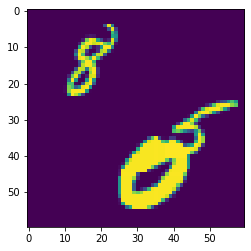

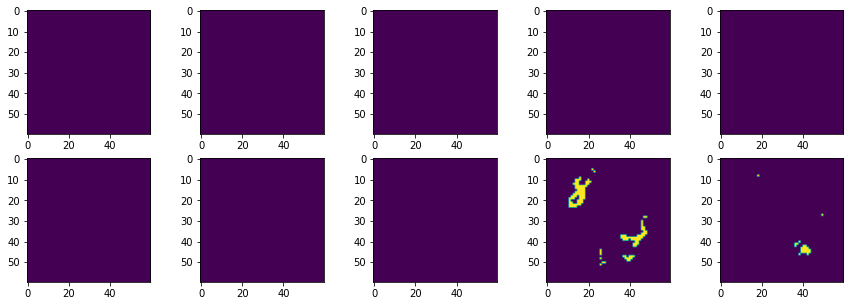

****


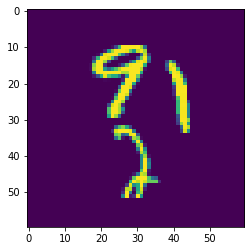

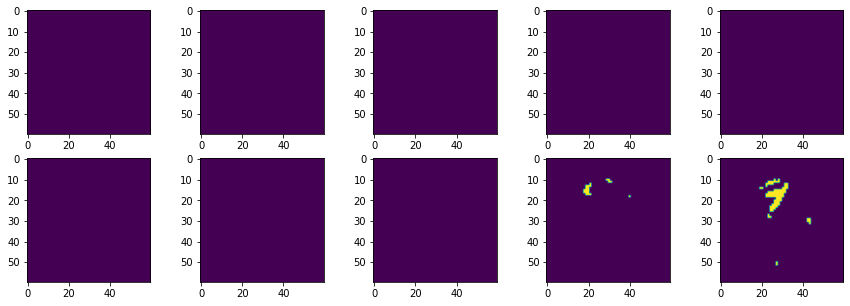

****


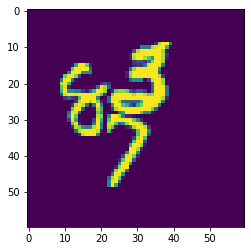

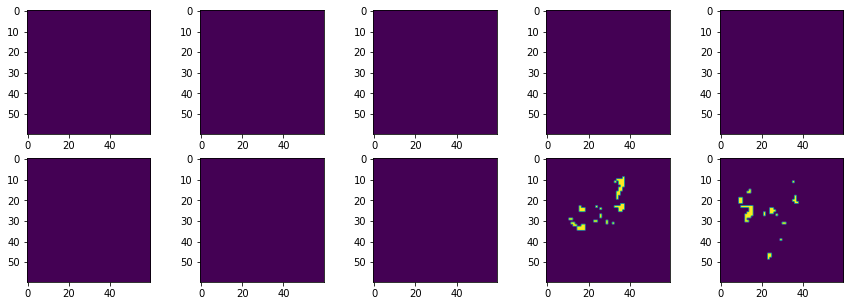

****


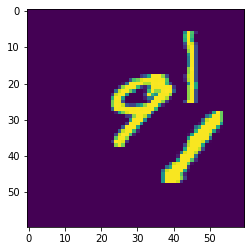

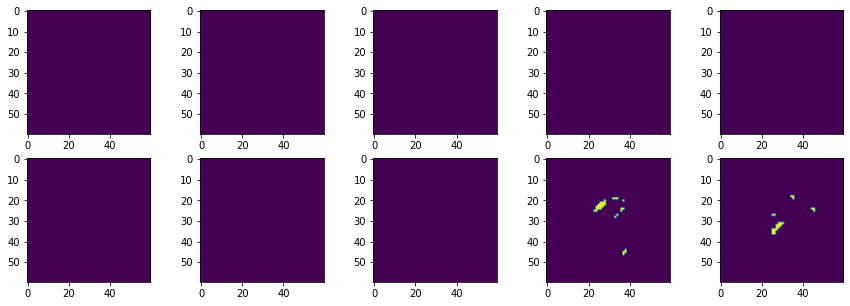

****


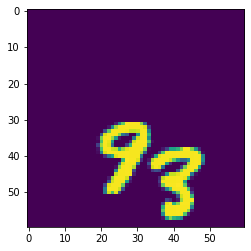

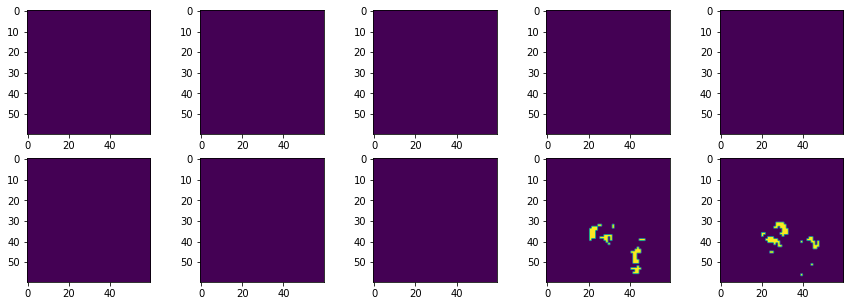

****


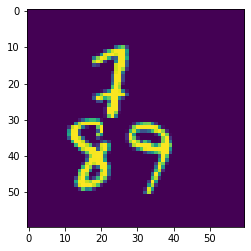

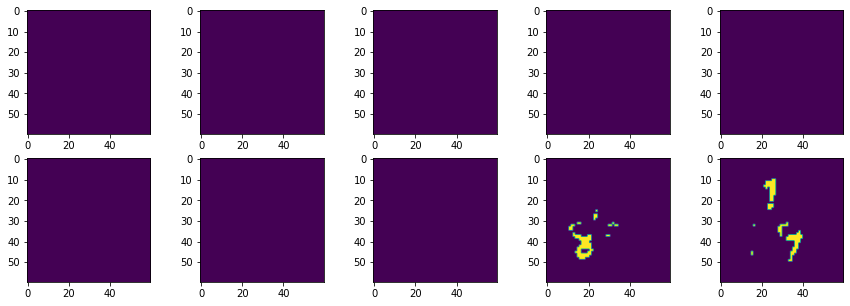

****


In [262]:
trainer.model.eval()
for j, (images, labels) in enumerate(test_loader):
  x = trainer.model(images.cuda().float())
  plt.imshow(images[0][0])
  plt.show()
  
  plt.figure(figsize=(15, 5))
  for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(x[0,i].detach().cpu()>0.3)
  plt.show()
  print("****")
  if j == 5:
    break